# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [1]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

In [2]:
saipe = pd.read_excel("../data/saipe19.xls", header=2).set_index("District ID")
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
District ID,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649
5,AL,1,Albertville City School District,22051,4131,957
30,AL,1,Alexander City City School District,16920,2575,703
60,AL,1,Andalusia City School District,8842,1465,406
90,AL,1,Anniston City School District,22043,3065,1057


Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [3]:
from dp_policy.titlei.utils import median_cv

saipe["median_cv"] = saipe.apply(lambda x: median_cv(x["Estimated Total Population"]), axis=1)
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,median_cv
District ID,,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649,0.23
5,AL,1,Albertville City School District,22051,4131,957,0.23
30,AL,1,Alexander City City School District,16920,2575,703,0.28
60,AL,1,Andalusia City School District,8842,1465,406,0.35
90,AL,1,Anniston City School District,22043,3065,1057,0.23


### Code

In [4]:
from dp_policy.titlei.mechanisms import GroundTruth

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [5]:
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting

weighting(1559, 10000)

1993.0

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


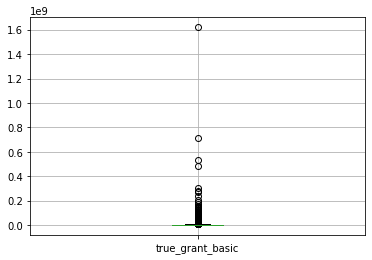

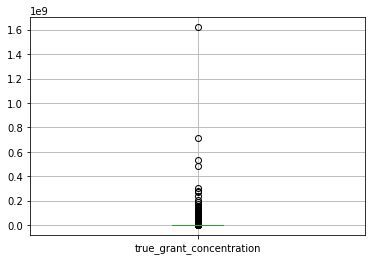

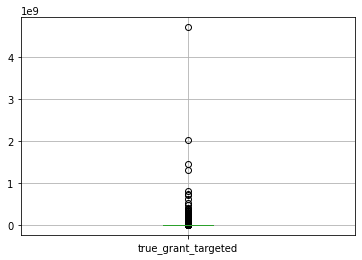

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [7]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

After estimation, privacy acc: (epsilon=0, delta=0.0)


(District ID
 190     3.467406e+04
 5       2.200819e+04
 30      1.690265e+04
 60      8.830932e+03
 90      2.204648e+04
             ...     
 6240    7.103562e+03
 5820    6.183290e+02
 4830    5.488676e+03
 6090    1.458294e+03
 30      3.193697e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 District ID
 190       6697.224330
 5         4141.837102
 30        2571.850512
 60        1473.186938
 90        3074.228281
             ...      
 6240      1297.185052
 5820        98.206707
 4830       830.956397
 6090       250.882883
 30      455229.741990
 Name: Estimated Population 5-17, Length: 13184, dtype: float64,
 District ID
 190        638.110594
 5          943.220196
 30         717.057805
 60         408.750987
 90        1055.518215
             ...      
 6240       152.505671
 5820         1.648289
 4830       108.039212
 6090         1.088709
 30      248604.301333
 Name: Estimated number of relevant children 5 to 17 years old in poverty who are 

### Results
First, using the full Sonnenberg authorization algo.

In [8]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

After estimation, privacy acc: (epsilon=0, delta=0.0)
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State FIPS Code,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,29.561751,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049290e+03,625.253874,625.253224,625.253874,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026322e+06,2.232440e+06,5.062042e+06
std,14.644764,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728792e+04,3467.139638,3467.140325,3467.139638,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912447e+07,1.908714e+07,5.239816e+07
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.150000,1.056819e-01,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18.000000,2.802000e+03,4.260000e+02,52.000000,0.230000,2.801902e+03,4.260095e+02,52.040705,52.000000,52.040705,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.607861e+05,0.000000e+00,1.929135e+05
50%,30.000000,7.911000e+03,1.186000e+03,147.000000,0.350000,7.910940e+03,1.185995e+03,147.053098,147.000000,147.053098,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.502325e+05,0.000000e+00,7.274563e+05
75%,40.000000,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101813e+04,3.221926e+03,411.143437,411.000000,411.143437,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.078276e+06,9.162849e+05,2.292895e+06
max,56.000000,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259012.340006,259012.000000,259012.340006,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619699e+09,1.619699e+09,4.714294e+09


In [9]:
eps = list(np.logspace(-3, 1)) + [2.5]
allocations = []
for e in eps:
    print(e, end=" ")
    allocations.append(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, e, 0), get_sppe("../data/sppe18.xlsx"), weighting, verbose=False))

0.001 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0012067926406393288 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0014563484775012444 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0017575106248547913 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0021209508879201904 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.002559547922699536 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0030888435964774815 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.003727593720314938 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.004498432668969444 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.005428675439323859 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.006551285568595509 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.0079060432109077 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.009540954763499945 After estimation, privacy acc: (epsilon=0, delta=0.0)
0.01151395399326447 After estimation,

## basic grants ##
RMSE at eps=0.10985411419875583: 65425.56347938797
Total misalloc at eps=0.10985411419875583: 597204953.3294117
Total true alloc: 39894838662.272514
RMSE at eps=2.5: 4035.342233168439
Total misalloc at eps=2.5: 27351543.56997192
Total true alloc: 39894838662.272514


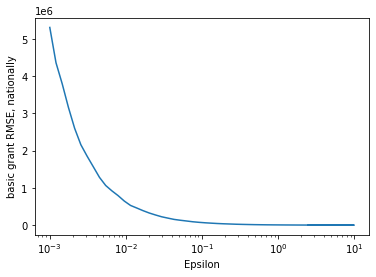

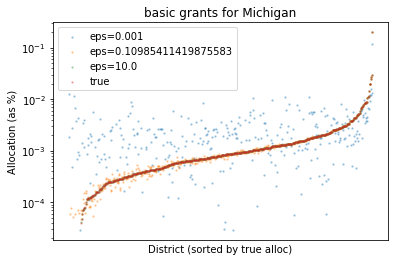

<ipython-input-10-1af3c61de18a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


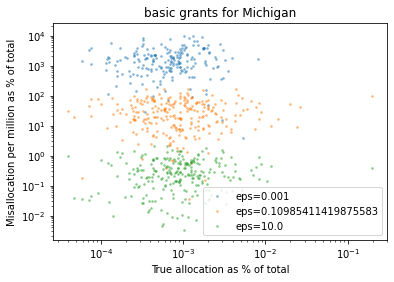

## concentration grants ##
RMSE at eps=0.10985411419875583: 196037.67609630575
Total misalloc at eps=0.10985411419875583: 605737064.4323438
Total true alloc: 29421416873.03583
RMSE at eps=2.5: 26465.387454449046
Total misalloc at eps=2.5: 22118778.914135262
Total true alloc: 29421416873.03583


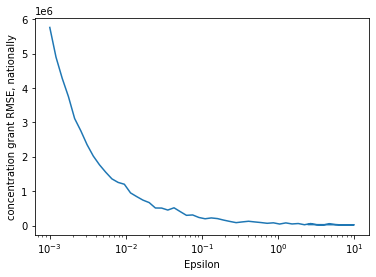

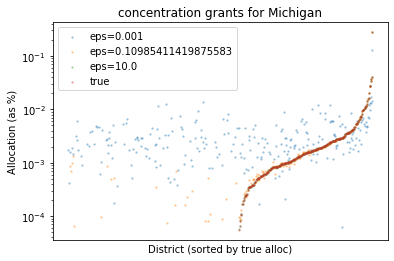

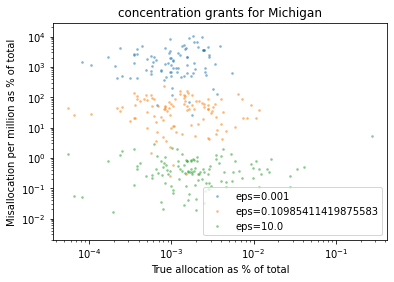

## targeted grants ##
RMSE at eps=0.10985411419875583: 135250.69455353025
Total misalloc at eps=0.10985411419875583: 965141343.5805094
Total true alloc: 66729811774.698265
RMSE at eps=2.5: 16414.407837385028
Total misalloc at eps=2.5: 43355208.92803148
Total true alloc: 66729811774.698265


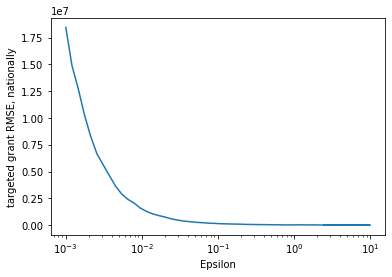

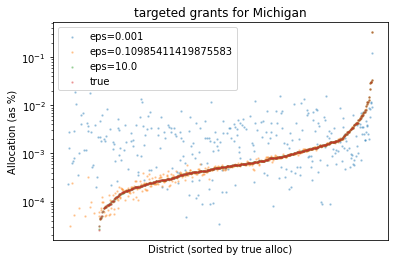

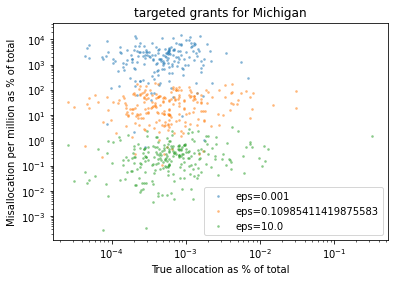

In [10]:
for grant_type in ("basic", "concentration", "targeted"):
    print(f"## {grant_type} grants ##")
    mse = []
    for alloc, e in zip(allocations, eps):
        error = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
        mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
        if (e == 2.5) or (e > 0.1 and e < 0.11):
            print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
            print(f"Total misalloc at eps={e}:", sum(abs(error)))
            print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))

    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        plt.scatter(alloc.index.astype('str'), alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(alloc.index.astype('str'), alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation (as %)")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [11]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [12]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2808.096653626409

In [13]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 25905156.62392847


In [14]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1520.0499568854718

In [15]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70210.78595666462

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

### Uncertainty

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

In [16]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.head()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State Postal Code,State FIPS Code,Name,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,adj_sppe,true_allocation,est_allocation
0,AL,1,Alabaster City School District,34669,6710,649,0.23,34668.486335,6709.787500,647.654652,649,647.654652,9697.0,4168.910429,2.705623e+06,2.700014e+06
1,AL,1,Albertville City School District,22051,4131,957,0.23,22051.174743,4131.167440,956.356390,957,956.356390,9697.0,4168.910429,3.989647e+06,3.986964e+06
2,AL,1,Alexander City City School District,16920,2575,703,0.28,16920.039739,2574.273216,702.966656,703,702.966656,9697.0,4168.910429,2.930744e+06,2.930605e+06
3,AL,1,Andalusia City School District,8842,1465,406,0.35,8842.644897,1464.574813,406.124279,406,406.124279,9697.0,4168.910429,1.692578e+06,1.693096e+06
4,AL,1,Anniston City School District,22043,3065,1057,0.23,22043.406944,3066.040422,1057.689321,1057,1057.689321,9697.0,4168.910429,4.406538e+06,4.409412e+06


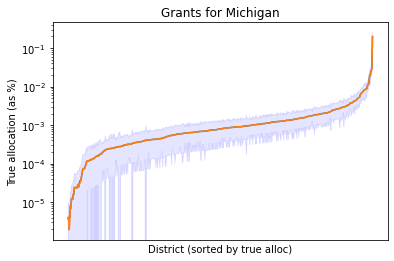

In [17]:
grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
x = grants.index.astype('str')
y = grants.true_allocation / sum(grants.true_allocation)
plt.plot(x, y)
ax = plt.gca()
prop_ci = 1.96 * grants.median_cv * y
ax.fill_between(x, (y-prop_ci), (y+prop_ci), color='b', alpha=0.1)

plt.plot(x, grants.est_allocation / sum(grants.est_allocation))

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan")
plt.show()

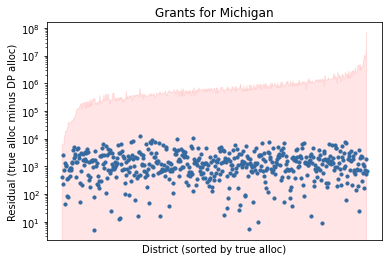

In [18]:
grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
x = grants.index.astype('str')
y = np.abs(grants.true_allocation - grants.est_allocation)
plt.scatter(x, y, s=10)

ax = plt.gca()
ci = 1.96 * grants.median_cv * grants.true_allocation
ax.fill_between(x, ci, color='r', alpha=0.1)

ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("Residual (true alloc minus DP alloc)")
plt.title(f"Grants for Michigan")
plt.show()

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.